# Text Classification with GNN

In [1]:
import torchtext
import torchdata
import dgl
import torch
import numpy
torchtext.__version__, torchdata.__version__, dgl.__version__, torch.__version__, numpy.__version__

('0.14.0', '0.5.0', '0.9.1', '1.13.0', '1.26.0')

### Introduction

In this tutorial demo, we will use the Graph4NLP library to build a GNN-based text classification model. The model consists of 
- graph construction module (e.g., dependency based static graph)
- graph embedding module (e.g., Bi-Fuse GraphSAGE)
- prediction module (e.g., graph pooling + MLP classifier)

We will use the built-in module APIs to build the model, and evaluate it on the TREC dataset.

### Environment setup

In [2]:
import argparse
import os
import time
import datetime
import numpy as np
import torch
import torch.backends.cudnn as cudnn
import torch.multiprocessing
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import yaml
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
import dgl

from graph4nlp.pytorch.datasets.trec import TrecDataset
from graph4nlp.pytorch.data.data import from_batch
from graph4nlp.pytorch.modules.evaluation.accuracy import Accuracy
from graph4nlp.pytorch.modules.graph_construction import (
    NodeEmbeddingBasedGraphConstruction,
    NodeEmbeddingBasedRefinedGraphConstruction,
)
from graph4nlp.pytorch.modules.graph_embedding_initialization.embedding_construction import (
    WordEmbedding,
)
from graph4nlp.pytorch.modules.graph_embedding_initialization.graph_embedding_initialization import (  # noqa
    GraphEmbeddingInitialization,
)
from graph4nlp.pytorch.modules.graph_embedding_learning import GAT, GGNN, GraphSAGE
from graph4nlp.pytorch.modules.loss.general_loss import GeneralLoss
from graph4nlp.pytorch.modules.prediction.classification.graph_classification import FeedForwardNN
from graph4nlp.pytorch.modules.utils import constants as Constants
from graph4nlp.pytorch.modules.utils.generic_utils import EarlyStopping, grid, to_cuda
from graph4nlp.pytorch.modules.utils.logger import Logger

import networkx as nx

### Build the text classifier

In [3]:
dataset = TrecDataset(
    root_dir='../data/trec',
    topology_subdir='dependency_graph',
    graph_name='dependency',
    pretrained_word_emb_name='840B',
    merge_strategy='tailhead',
    edge_strategy='homogeneous',
    word_emb_size=300,
    seed=1234,
    reused_label_model=None,
)

Loading pre-built label mappings stored in ../data/trec/processed/dependency_graph/label.pt


/Users/vitaliypozdnyakov/miniconda3/envs/text2graph/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.0.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


The Text REtrieval Conference (TREC) Question Classification dataset contains 5500 labeled questions in training set and another 500 for test set.

The dataset has 6 coarse class labels and 50 fine class labels. Average length of each sentence is 10, vocabulary size of 8700.

Data are collected from four sources: 4,500 English questions published by USC (Hovy et al., 2001), about 500 manually constructed questions for a few rare classes, 894 TREC 8 and TREC 9 questions, and also 500 questions from TREC 10 which serves as the test set. These questions were manually labeled.

Coarse class label. Possible values are:
* 'ABBR' (0): Abbreviation.
* 'ENTY' (1): Entity.
* 'DESC' (2): Description and abstract concept.
* 'HUM' (3): Human being.
* 'LOC' (4): Location.
* 'NUM' (5): Numeric value.

In [4]:
train_dataloader = DataLoader(
    dataset.train,
    batch_size=50,
    shuffle=True,
    collate_fn=dataset.collate_fn,
)
val_dataloader = DataLoader(
    dataset.test[250:],
    batch_size=50,
    shuffle=False,
    collate_fn=dataset.collate_fn,
)
test_dataloader = DataLoader(
    dataset.test[:250],
    batch_size=50,
    shuffle=False,
    collate_fn=dataset.collate_fn,
)

In [65]:
data_item = train_dataloader.dataset[14]

data_item.input_text

'What is considered the costliest disaster the insurance industry has ever faced ?'

In [66]:
data_item.output_label

'ENTY'

In [67]:
graph = data_item.graph
graph.get_node_attrs(0)

{'node_attr': None,
 'type': 0,
 'token': 'What',
 'position_id': 0,
 'sentence_id': 0,
 'head': True,
 'tail': False,
 'token_id': 14}

In [68]:
[graph.get_node_attrs(i)['token'] for i in range(len(graph.nodes))]

['What',
 'is',
 'considered',
 'the',
 'costliest',
 'disaster',
 'the',
 'insurance',
 'industry',
 'has',
 'ever',
 'faced',
 '?']

In [69]:
[graph.get_node_attrs(i)['token_id'] for i in range(len(graph.nodes))]

[14, 38, 85, 17, 86, 87, 17, 88, 89, 90, 91, 92, 13]

In [70]:
[graph.get_node_attrs(i)['head'] for i in range(len(graph.nodes))]

[True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False]

In [71]:
[graph.get_node_attrs(i)['tail'] for i in range(len(graph.nodes))]

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True]

In [72]:
graph.get_node_features(0)

{'node_feat': None, 'node_emb': None, 'token_id': tensor([14])}

In [73]:
graph.get_edge_feature((0, 1))

{'edge_feat': None, 'edge_emb': None, 'edge_weight': None}

In [79]:
graph.get_all_edges()

[(2, 0),
 (2, 1),
 (5, 3),
 (5, 4),
 (2, 5),
 (8, 6),
 (8, 7),
 (11, 8),
 (11, 9),
 (11, 10),
 (5, 11),
 (2, 12)]

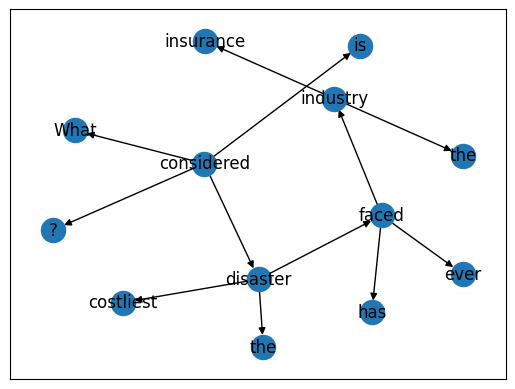

In [82]:
G = nx.from_edgelist(graph.get_all_edges(), create_using=nx.DiGraph)
#G = nx.relabel_nodes(G, )
nx.draw_networkx(
    G, 
    labels={i: graph.get_node_attrs(i)['token'] for i in range(len(graph.nodes))}
)

Let's first build the GNN-based text classifier which contains three major components including graph construction module, graph embedding module and graph prediction module. 

For graph construction module, the Graph4NLP library provides built-in APIs to support both static graph construction methods (e.g., `dependency graph`, `constituency graph`, `IE graph`) and dynamic graph construction methods (e.g., `node embedding based graph`, `node embedding based refined graph`). When calling the graph construction API, users should also specify the `embedding style` (e.g., word2vec, BiLSTM, BERT) to initialize the node/edge embeddings. Both single-token and multi-token node/edge graphs are supported.

For graph embedding module, the Graph4NLP library provides builti-in APIs to support both `undirectional` and `bidirectinal` versions for common GNNs such as `GCN`, `GraphSAGE`, `GAT` and `GGNN`. 

For graph prediction module, the Graph4NLP library provides a high-level graph classification prediction module which consists of a graph pooling component (e.g., average pooling, max pooling) and a multilayer perceptron (MLP).

In [83]:
config_file = '../config/trec/graphsage_bi_fuse_static_dependency_v2.yaml'
config = yaml.load(open(config_file, 'r'), Loader=yaml.FullLoader)
config['epochs'] = 10
config

{'dataset': 'trec',
 'val_split_ratio': 0.2,
 'pretrained_word_emb_name': '840B',
 'out_dir': 'out/trec/graphsage_bi_fuse_dependency_ckpt',
 'graph_construction_args': {'graph_construction_share': {'graph_name': 'dependency',
   'root_dir': '../data/trec',
   'thread_number': 10,
   'port': 9000,
   'timeout': 15000},
  'graph_construction_private': {'edge_strategy': 'homogeneous',
   'merge_strategy': 'tailhead',
   'sequential_link': True,
   'as_node': False,
   'dynamic_init_graph_name': None}},
 'gl_metric_type': None,
 'gl_epsilon': None,
 'gl_top_k': None,
 'gl_num_heads': 1,
 'gl_num_hidden': 300,
 'gl_smoothness_ratio': None,
 'gl_sparsity_ratio': None,
 'gl_connectivity_ratio': None,
 'init_adj_alpha': None,
 'word_dropout': 0.4,
 'rnn_dropout': 0.1,
 'no_fix_word_emb': False,
 'emb_strategy': 'w2v_bilstm',
 'gnn': 'graphsage',
 'gnn_direction_option': 'bi_fuse',
 'gnn_num_layers': 1,
 'num_hidden': 300,
 'graph_pooling': 'avg_pool',
 'max_pool_linear_proj': False,
 'gnn_drop

In [86]:
class TextClassifier(nn.Module):
    def __init__(self, vocab, label_model, config):
        super(TextClassifier, self).__init__()
        self.config = config
        self.vocab_model = vocab
        self.label_model = label_model
        self.graph_name = 'dependency'
        hidden_dim = 300
        
        embedding_style = {
            "single_token_item": True if self.graph_name != "ie" else False,
            "emb_strategy": "w2v_bilstm",
            "num_rnn_layers": 1,
            "bert_model_name": "bert-base-uncased",
            "bert_lower_case": True,
        }

        self.graph_initializer = GraphEmbeddingInitialization(
            word_vocab=self.vocab_model.in_word_vocab,
            embedding_style=embedding_style,
            hidden_size=config["num_hidden"],
            word_dropout=config["word_dropout"],
            rnn_dropout=config["rnn_dropout"],
            fix_word_emb=not config["no_fix_word_emb"],
            fix_bert_emb=not config.get("no_fix_bert_emb", False),
        )

        use_edge_weight = False

        self.word_emb = self.graph_initializer.embedding_layer.word_emb_layers[
            "w2v"
        ].word_emb_layer
        
        self.gnn = GraphSAGE(
            config["gnn_num_layers"],
            config["num_hidden"],
            config["num_hidden"],
            config["num_hidden"],
            config["graphsage_aggreagte_type"],
            direction_option=config["gnn_direction_option"],
            feat_drop=config["gnn_dropout"],
            bias=True,
            norm=None,
            activation=F.relu,
            use_edge_weight=use_edge_weight,
        )
        self.clf = FeedForwardNN(
            config["num_hidden"],
            label_model.num_classes,
            [config["num_hidden"]],
            graph_pool_type=config["graph_pooling"],
            dim=config["num_hidden"],
            use_linear_proj=config["max_pool_linear_proj"],
        )

        self.loss = GeneralLoss("CrossEntropy")

    def forward(self, graph_list, tgt=None, require_loss=True):
        # graph embedding initialization
        batch_gd = self.graph_initializer(graph_list)

        # run GNN
        self.gnn(batch_gd)

        # run graph classifier
        self.clf(batch_gd)
        logits = batch_gd.graph_attributes["logits"]

        if require_loss:
            loss = self.loss(logits, tgt)
            return logits, loss
        else:
            return logits

    def inference_forward(self, collate_data):
        return self.forward(collate_data["graph_data"], require_loss=False)

    def post_process(self, logits, label_names):
        logits_list = []

        for idx in range(len(logits)):
            logits_list.append(logits[idx].cpu().clone().numpy())

        pred_tags = [label_names[pred.argmax()] for pred in logits_list]
        return pred_tags

    @classmethod
    def load_checkpoint(cls, model_path):
        """The API to load the model.

        Parameters
        ----------
        model_path : str
            The saved model path.

        Returns
        -------
        Class
        """
        return torch.load(model_path)

In [93]:
for batch in test_dataloader:
    break
model = TextClassifier(dataset.vocab_model, dataset.label_model, config)
logits = model.inference_forward(batch)
#torch.softmax(logits, dim=1)
pred = logits.argmax(1)
pred

[ Fix word embeddings ]


tensor([0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])

In [94]:
batch['tgt_tensor']

tensor([5, 4, 3, 1, 5, 5, 3, 2, 1, 1, 4, 3, 5, 3, 5, 5, 2, 3, 1, 5, 3, 1, 4, 1,
        1, 3, 1, 4, 4, 4, 5, 4, 1, 5, 5, 5, 4, 5, 5, 5, 2, 1, 1, 1, 2, 2, 5, 1,
        5, 3])

In [95]:
sum(pred == batch['tgt_tensor']) / len(pred)

tensor(0.0600)

### Build the model handler

Next, let's build a model handler which will do a bunch of things including setting up dataloader, model, optimizer, evaluation metrics, train/val/test loops, and so on.

When setting up the dataloader, users will need to call the dataset API which will preprocess the data, e.g., calling the graph construction module, building the vocabulary, tensorizing the data. Users will need to specify the graph construction type when calling the dataset API.

Users can build their customized dataset APIs by inheriting our low-level dataset APIs. We provide low-level dataset APIs to support various scenarios (e.g., `Text2Label`, `Sequence2Labeling`, `Text2Text`, `Text2Tree`, `DoubleText2Text`).

In [96]:
class ModelHandler:
    def __init__(self, dataset, train_dataloader, val_dataloader, test_dataloader, config):
        super(ModelHandler, self).__init__()
        self.model = model
        self.config = config
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.test_dataloader = test_dataloader
        
        self.graph_name = 'dependency'
        self.vocab_model = dataset.vocab_model
        self.label_model = dataset.label_model
        self.config["num_classes"] = self.label_model.num_classes
        self.num_train = len(dataset.train)
        self.num_val = len(dataset.test) / 2
        self.num_test = len(dataset.test) / 2
        
        self.logger = Logger(
            self.config["out_dir"],
            config={k: v for k, v in self.config.items() if k != "device"},
            overwrite=True,
        )
        self.logger.write(self.config["out_dir"])
        self._build_optimizer()
        self._build_evaluation()

    def _build_optimizer(self):
        parameters = [p for p in self.model.parameters() if p.requires_grad]
        self.optimizer = optim.Adam(parameters, lr=self.config["lr"])
        self.stopper = EarlyStopping(
            os.path.join(
                self.config["out_dir"],
                self.config.get("model_ckpt_name", Constants._SAVED_WEIGHTS_FILE),
            ),
            patience=self.config["patience"],
        )
        self.scheduler = ReduceLROnPlateau(
            self.optimizer,
            mode="max",
            factor=self.config["lr_reduce_factor"],
            patience=self.config["lr_patience"],
            verbose=True,
        )

    def _build_evaluation(self):
        self.metric = Accuracy(["accuracy"])

    def train(self):
        dur = []
        for epoch in range(self.config["epochs"]):
            self.model.train()
            train_loss = []
            train_acc = []
            t0 = time.time()
            for data in self.train_dataloader:
                tgt = to_cuda(data["tgt_tensor"], self.config["device"])
                data["graph_data"] = data["graph_data"].to(self.config["device"])
                logits, loss = self.model(data["graph_data"], tgt, require_loss=True)

                # add graph regularization loss if available
                if data["graph_data"].graph_attributes.get("graph_reg", None) is not None:
                    loss = loss + data["graph_data"].graph_attributes["graph_reg"]

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                train_loss.append(loss.item())

                pred = torch.max(logits, dim=-1)[1].cpu()
                train_acc.append(
                    self.metric.calculate_scores(ground_truth=tgt.cpu(), predict=pred.cpu())[0]
                )
                dur.append(time.time() - t0)

            val_acc = self.evaluate(self.val_dataloader)
            self.scheduler.step(val_acc)
            print(
                "Epoch: [{} / {}] | Time: {:.2f}s | Loss: {:.4f} |"
                "Train Acc: {:.4f} | Val Acc: {:.4f}".format(
                    epoch + 1,
                    self.config["epochs"],
                    np.mean(dur),
                    np.mean(train_loss),
                    np.mean(train_acc),
                    val_acc,
                )
            )
            self.logger.write(
                "Epoch: [{} / {}] | Time: {:.2f}s | Loss: {:.4f} |"
                "Train Acc: {:.4f} | Val Acc: {:.4f}".format(
                    epoch + 1,
                    self.config["epochs"],
                    np.mean(dur),
                    np.mean(train_loss),
                    np.mean(train_acc),
                    val_acc,
                )
            )

            if self.stopper.step(val_acc, self.model):
                break

        return self.stopper.best_score

    def evaluate(self, dataloader):
        self.model.eval()
        with torch.no_grad():
            pred_collect = []
            gt_collect = []
            for data in dataloader:
                tgt = to_cuda(data["tgt_tensor"], self.config["device"])
                data["graph_data"] = data["graph_data"].to(self.config["device"])
                logits = self.model(data["graph_data"], require_loss=False)
                pred_collect.append(logits)
                gt_collect.append(tgt)

            pred_collect = torch.max(torch.cat(pred_collect, 0), dim=-1)[1].cpu()
            gt_collect = torch.cat(gt_collect, 0).cpu()
            score = self.metric.calculate_scores(ground_truth=gt_collect, predict=pred_collect)[0]

            return score

    def test(self):
        # restored best saved model
        self.model = TextClassifier.load_checkpoint(self.stopper.save_model_path)

        t0 = time.time()
        acc = self.evaluate(self.test_dataloader)
        dur = time.time() - t0
        print(
            "Test examples: {} | Time: {:.2f}s |  Test Acc: {:.4f}".format(self.num_test, dur, acc)
        )
        self.logger.write(
            "Test examples: {} | Time: {:.2f}s |  Test Acc: {:.4f}".format(self.num_test, dur, acc)
        )

        return acc

### Run the model

In [97]:
# run model
np.random.seed(config['seed'])
torch.manual_seed(config['seed'])

config["device"] = torch.device("cpu")

ts = datetime.datetime.now().timestamp()
config['out_dir'] += '_{}'.format(ts)

runner = ModelHandler(dataset, train_dataloader, val_dataloader, test_dataloader, config)

In [98]:
t0 = time.time()

val_acc = runner.train()
test_acc = runner.test()

runtime = time.time() - t0
print('Total runtime: {:.2f}s'.format(runtime))
runner.logger.write('Total runtime: {:.2f}s\n'.format(runtime))
runner.logger.close()

print('val acc: {}, test acc: {}'.format(val_acc, test_acc))

/Users/vitaliypozdnyakov/miniconda3/envs/text2graph/lib/python3.10/site-packages/graph4nlp/pytorch/modules/evaluation/accuracy.py:157: UserWarning: zero division encountered
  warnings.warn("zero division encountered")


Epoch: [1 / 10] | Time: 3.72s | Loss: 1.1985 |Train Acc: 0.5215 | Val Acc: 0.8000
Saved model to out/trec/graphsage_bi_fuse_dependency_ckpt_1729184049.976415/params.saved
Epoch: [2 / 10] | Time: 3.72s | Loss: 0.6682 |Train Acc: 0.7549 | Val Acc: 0.8200
Saved model to out/trec/graphsage_bi_fuse_dependency_ckpt_1729184049.976415/params.saved
Epoch: [3 / 10] | Time: 3.71s | Loss: 0.5162 |Train Acc: 0.8129 | Val Acc: 0.8840
Saved model to out/trec/graphsage_bi_fuse_dependency_ckpt_1729184049.976415/params.saved
Epoch: [4 / 10] | Time: 3.70s | Loss: 0.4277 |Train Acc: 0.8467 | Val Acc: 0.8560
EarlyStopping counter: 1 out of 10
Epoch: [5 / 10] | Time: 3.70s | Loss: 0.3823 |Train Acc: 0.8642 | Val Acc: 0.9240
Saved model to out/trec/graphsage_bi_fuse_dependency_ckpt_1729184049.976415/params.saved
Epoch: [6 / 10] | Time: 3.70s | Loss: 0.3188 |Train Acc: 0.8864 | Val Acc: 0.8680
EarlyStopping counter: 1 out of 10
Epoch: [7 / 10] | Time: 3.70s | Loss: 0.2914 |Train Acc: 0.8938 | Val Acc: 0.9280


In [104]:
logits = model.inference_forward(batch)
#torch.softmax(logits, dim=1).detach().numpy().round(2)
pred = logits.argmax(1)
pred

tensor([5, 4, 3, 1, 5, 5, 2, 2, 1, 1, 4, 3, 5, 3, 5, 5, 2, 3, 1, 5, 3, 1, 4, 1,
        1, 3, 1, 2, 4, 4, 5, 4, 1, 5, 5, 5, 4, 5, 5, 5, 2, 1, 1, 1, 2, 2, 5, 1,
        5, 3])

In [106]:
batch['tgt_tensor']

tensor([5, 4, 3, 1, 5, 5, 3, 2, 1, 1, 4, 3, 5, 3, 5, 5, 2, 3, 1, 5, 3, 1, 4, 1,
        1, 3, 1, 4, 4, 4, 5, 4, 1, 5, 5, 5, 4, 5, 5, 5, 2, 1, 1, 1, 2, 2, 5, 1,
        5, 3])

In [107]:
sum(pred == batch['tgt_tensor']) / len(pred)

tensor(0.9600)